In [1]:
! pip install textacy -q

In [2]:
# imports - usual suspects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from afinn import Afinn
import spacy
from spacy import cli
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy import displacy
import textdescriptives as td
import tokenwiser
import textacy

cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
SQL_train = "SELECT * from `questrom.SMSspam.train`"
SQL_test = "SELECT * from `questrom.SMSspam.test`"

YOUR_BILLING_PROJECT = "ba820-329602"
train_spam = pd.read_gbq(SQL_train, YOUR_BILLING_PROJECT)
test_spam = pd.read_gbq(SQL_test, YOUR_BILLING_PROJECT)

In [4]:
train_spam.sample(2)

,message,label,id
173,Hmmm... Guess we can go 4 kb n power yoga... H...,ham,235
1553,Solve d Case : A Man Was Found Murdered On &l...,ham,2036


## CV

In [5]:
cv = CountVectorizer(token_pattern="\S+")
dtm = cv.fit_transform(train_spam['message'])

In [6]:
df_cv = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())

In [7]:
X = df_cv 
y = train_spam['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [8]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=30, min_samples_leaf=15)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=30)

In [9]:
pred = tree.predict(X_test)

In [10]:
accuracy = accuracy_score(pred, y_test)
accuracy

0.9296998420221169

### Submission

In [11]:
cv.transform(test_spam['message'])
df_cv_sub= pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())
pred_sub = tree.predict(df_cv_sub)
pred_sub

array(['ham', 'ham', 'ham', ..., 'spam', 'spam', 'spam'], dtype=object)

### UMAP

In [12]:
import umap.umap_ as umap
u_map = umap.UMAP(2)
u2 = u_map.fit_transform(dtm)

In [13]:
X = u2 
y = train_spam['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=30, min_samples_leaf=15)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
accuracy = accuracy_score(pred, y_test)
accuracy

0.8546603475513428

## TFIDF

In [14]:
u_map = umap.UMAP(2)
tv = TfidfVectorizer(token_pattern="\S+", ngram_range=(1,5))
dtm_tv = tv.fit_transform(train_spam['message'])
#dtm_tv = u_map.fit_transform(tv.fit_transform(train_spam['message']))

In [15]:
df_tv = pd.DataFrame(dtm_tv.toarray(), columns=tv.get_feature_names_out())
X = dtm_tv 
y = train_spam['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [16]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=30, min_samples_leaf=15)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
accuracy = accuracy_score(pred, y_test)
accuracy

0.9352290679304898

## Afinn

In [17]:
spam_message = train_spam.copy()
afinn = Afinn()

In [18]:
affinn_score = spam_message['message'].astype("str").apply(afinn.score)
spam_message['affinn_score'] = affinn_score
spam_message

,message,label,id,affinn_score
0,"Go until jurong point, crazy.. Available only ...",ham,1,1.0
1,Ok lar... Joking wif u oni...,ham,2,0.0
2,U dun say so early hor... U c already then say...,ham,3,0.0
3,I HAVE A DATE ON SUNDAY WITH WILL!!,ham,9,0.0
4,Fine if that’s the way u feel. That’s the way ...,ham,12,2.0
...,...,...,...,...
3830,PRIVATE! Your 2003 Account Statement for shows...,spam,4228,2.0
3831,Want explicit SEX in 30 secs? Ring 02073162414...,spam,4238,1.0
3832,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,spam,4240,-1.0
3833,Had your contract mobile 11 Mnths? Latest Moto...,spam,4245,1.0


### spacy text blob

In [19]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

In [20]:
docs = list(nlp.pipe(spam_message['message']))

In [21]:
sent_spacy = []
sub_spacy = []
for doc in docs:
    sent_spacy.append(doc._.polarity) # -1 to 1
    sub_spacy.append(doc._.subjectivity) # 0(Fact) to 1(Opinion)
    
spam_message['sent_spacy_score'] = sent_spacy
spam_message['sub_spacy_score'] = sub_spacy
spam_message.sample(2)

,message,label,id,affinn_score,sent_spacy_score,sub_spacy_score
1467,Do u noe how 2 send files between 2 computers?,ham,1923,0.0,0.0,0.0
694,Just wait till end of march when el nino gets ...,ham,941,0.0,0.0,0.0


### Summarization and Classification 

In [22]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")
nlp.add_pipe("textdescriptives") 

In [23]:
docs = nlp.pipe(spam_message['message'])
doc_df = td.extract_df(docs)

C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
doc_df.head(3)

,text,token_length_mean,token_length_median,token_length_std,sentence_length_mean,sentence_length_median,sentence_length_std,syllables_per_token_mean,syllables_per_token_median,syllables_per_token_std,...,pos_prop_INTJ,pos_prop_PRON,pos_prop_DET,pos_prop_SCONJ,pos_prop_X,pos_prop_AUX,pos_prop_PART,pos_prop_NUM,pos_prop_SPACE,pos_prop_SYM
0,"Go until jurong point, crazy.. Available only ...",4.15,5.0,1.904600,6.666667,5.0,2.357023,1.250000,1.0,0.433013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ok lar... Joking wif u oni...,3.00,3.0,1.527525,3.000000,3.0,1.000000,1.166667,1.0,0.372678,...,0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U dun say so early hor... U c already then say...,3.00,3.0,1.758098,5.500000,5.5,0.500000,1.000000,1.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='gunning_fog', ylabel='coleman_liau_index'>

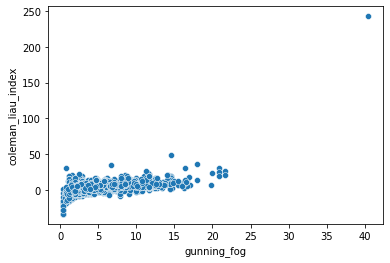

In [25]:
# what is the average grade using gunning_fog
doc_df.gunning_fog.describe()
sns.scatterplot(x="gunning_fog", y="coleman_liau_index", data=doc_df)

### NER

In [26]:
docs = nlp.pipe(spam_message['message'])
[(token.text, token.lemma_, token.pos_) for doc in docs for token in doc if not token.is_punct and not token.is_stop]

[('jurong', 'jurong', 'PROPN'),
 ('point', 'point', 'NOUN'),
 ('crazy', 'crazy', 'ADJ'),
 ('Available', 'available', 'ADJ'),
 ('bugis', 'bugis', 'ADJ'),
 ('n', 'n', 'CCONJ'),
 ('great', 'great', 'ADJ'),
 ('world', 'world', 'NOUN'),
 ('la', 'la', 'ADP'),
 ('e', 'e', 'PROPN'),
 ('buffet', 'buffet', 'PROPN'),
 ('Cine', 'Cine', 'PROPN'),
 ('got', 'get', 'VERB'),
 ('amore', 'amore', 'NOUN'),
 ('wat', 'wat', 'NOUN'),
 ('Ok', 'ok', 'INTJ'),
 ('lar', 'lar', 'ADJ'),
 ('Joking', 'joke', 'VERB'),
 ('wif', 'wif', 'NOUN'),
 ('u', 'u', 'PROPN'),
 ('oni', 'oni', 'NOUN'),
 ('U', 'U', 'PROPN'),
 ('dun', 'dun', 'PROPN'),
 ('early', 'early', 'ADJ'),
 ('hor', 'hor', 'NOUN'),
 ('U', 'U', 'PROPN'),
 ('c', 'c', 'VERB'),
 ('DATE', 'date', 'NOUN'),
 ('SUNDAY', 'SUNDAY', 'PROPN'),
 ('Fine', 'fine', 'INTJ'),
 ('way', 'way', 'NOUN'),
 ('u', 'u', 'NOUN'),
 ('feel', 'feel', 'VERB'),
 ('way', 'way', 'NOUN'),
 ('gota', 'gota', 'NOUN'),
 ('b', 'b', 'X'),
 ('seriously', 'seriously', 'ADV'),
 ('spell', 'spell', 'VERB'),

In [27]:
msg = ["Questrom is a business school at Boston University in Massachusetts", "Massachusetts is a Commonwealth State."]
docs = nlp.pipe(msg)
#[doc.ents for doc in docs]
ents = [(ent.text,ent.label_) for doc in docs for ent in doc.ents]

<AxesSubplot:>

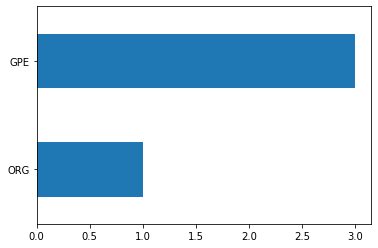

In [28]:
df = pd.DataFrame(ents, columns=['text', 'entity'])
counts = df.entity.value_counts()
counts.sort_values().plot(kind="barh")

In [29]:
#displacy.render(doc, style="ent", jupyter=True)

### Word Vector

In [30]:
model = "en_core_web_lg"
nlp = spacy.load(model)

In [31]:
EXCL = ['tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
docs = nlp.pipe(train_spam['message'], disable=EXCL)

In [32]:
X =  np.array([doc.vector for doc in docs])
y = train_spam['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
tree = RandomForestClassifier(max_depth=5, min_samples_split=30, min_samples_leaf=15)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
accuracy = accuracy_score(pred, y_test)
accuracy

0.9541864139020537

In [33]:
docs = nlp.pipe(test_spam['message'])
X_sub = np.array([doc.vector for doc in docs])
pred = tree.predict(X_sub)